In [1]:
from data_utils import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from feature_utils import *
from functions import *
import json
import random

/Users/sophia01px2019/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/sophia01px2019/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


# Task B: Damage Level Classification

Create a damage level classifier for the `hurricane-matthew` disaster.

## Feature Engineering

Which features are useful for this classification task? Construct them here.

We have around 5000 points with a label one, and we have 1500 points with a label of two. There are two ways we can work with this knowledge. First, we can built a dataset where we have the same number of datapoints for each label. Then, we can try weighing the inputs by their length to make a less-occuring label have a higher impact on the direction of the model.

1    5236
0    2631
3    1740
2 1544nt64

### DataSet1: Same Number of Datapoints per Label

In [2]:
# smallest number of images for a given label is 1544
data_dir = "satellite-image-data"
hurricane_features = pd.read_csv("hurricane_equal_labels.csv")

,Sobel_Edges,LBP,Red_Log,Green_Log,Gabor,Label
count,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000
mean,0.885763,16.916395,7.241595,7.523252,6.458311,1.500000
std,0.498158,1.271751,0.555298,0.525819,3.643570,1.118125
min,0.033381,9.833333,4.485958,4.716797,0.344656,0.000000
25%,0.525074,15.979694,6.881235,7.190165,4.000047,0.750000
50%,0.789928,16.922966,7.226459,7.509186,5.537527,1.500000
75%,1.144976,17.951635,7.609574,7.858637,7.888315,2.250000
max,4.856648,21.339560,9.093276,9.218051,31.501951,3.000000


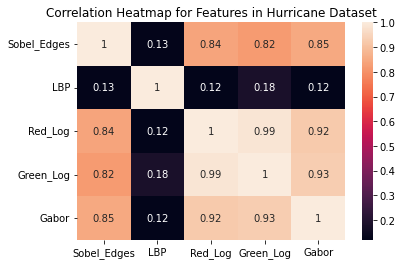

In [3]:
# Correlation heatmap for all features

features_only = hurricane_features.drop(columns = ["Label"])
heatmap = sns.heatmap(features_only.corr(), annot = True)
heatmap.set_title("Correlation Heatmap for Features in Hurricane Dataset")

hurricane_features.describe()

## Model Training

Decide on an appropriate model and train it here. It may be necessary to compare between different types of models, and also tune hyperparameters later.

Use the same models used above by Marei and Sophia to compare performance, then see if it is possible to improve the network architecture for the CNN, or if we need to prepare our data differently for this dataset

In [4]:
# function definitions and imports for this section
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


# functions 

def calculate_correlations(data, target='Label'):
    correlations = {}
    for column in data.columns:
        if column != target and pd.api.types.is_numeric_dtype(data[column]):
            correlation = data[[column, target]].corr().iloc[0, 1]
            correlations[column] = correlation
    correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation with Label'])
    
    print(correlation_df.sort_values(by='Correlation with Label', ascending=False))
    
    return correlation_df

def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values.
    """
    return np.sqrt(mean_squared_error(actual, predicted)) 

def cross_entropy(predicted, actual):
    epsilon = 1e-15
    y_pred = np.clip(predicted, epsilon, 1 - epsilon)
    
    # Check if binary or multi-class
    if actual.ndim == 1:  # Binary classification (only one column of targets)
        # Compute binary cross-entropy
        loss = -np.mean(actual * np.log(y_pred) + (1 - actual) * np.log(1 - y_pred))
    else:  
        # Compute multi-class cross-entropy
        loss = -np.mean(np.sum(actual * np.log(y_pred), axis=1))
    
    return loss


In [5]:
X = hurricane_features.drop('Label', axis=1)
y = hurricane_features['Label']

# Scaling and Normalizing the data so that all feature data is between 0 and 1

scaler = MinMaxScaler(feature_range = (0,1))
sn_X = scaler.fit_transform(X)
sn_X = pd.DataFrame(sn_X, columns=X.columns, index=X.index)

sn_X.describe()

,Sobel_Edges,LBP,Red_Log,Green_Log,Gabor
count,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000
mean,0.176723,0.615585,0.598100,0.623483,0.196219
std,0.103282,0.110527,0.120525,0.116816,0.116941
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.101942,0.534177,0.519885,0.549484,0.117321
50%,0.156854,0.616156,0.594815,0.620358,0.166666
75%,0.230465,0.705557,0.677968,0.697992,0.242115
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(sn_X, y,test_size=0.20, random_state=42, stratify=y)

columns_list = hurricane_features.columns.tolist()
correlation_df = calculate_correlations(hurricane_features[columns_list])

model = LogisticRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

print(y_train.shape)

train_ce = cross_entropy(y_train_pred, y_train)
test_ce = cross_entropy(y_valid_pred, y_valid)

train_accuracy = accuracy_score(y_train_pred, y_train)
valid_accuracy = accuracy_score(y_valid_pred, y_valid)

print(f"Training CE: {train_ce:.2f}")
print(f"Validation CE: {test_ce:.2f}")

             Correlation with Label
LBP                        0.211722
Sobel_Edges               -0.023570
Red_Log                   -0.139005
Green_Log                 -0.159259
Gabor                     -0.167817
(4940,)
Training CE: -12.88
Validation CE: -11.26


/Users/sophia01px2019/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


When running the above model, I got an error saying that convergence failed and the total number of iterations was reached. This means that, from iteration to iteration, our error is greater than some built-in tolerance. While the score we receoved was good, I am doubtful that the model is truly converging onto some prediction criteria.

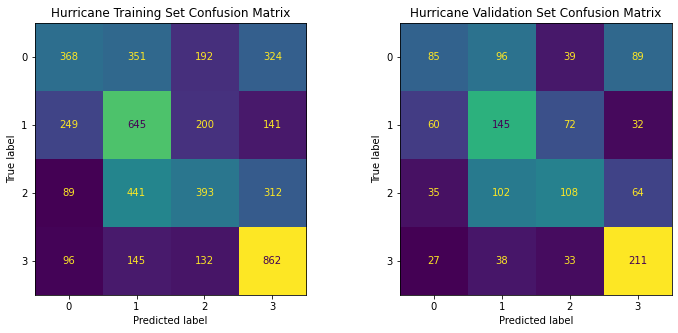

In [7]:
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_valid, y_valid_pred)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(train_cm, display_labels=[0, 1, 2, 3]).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Hurricane Training Set Confusion Matrix")
ConfusionMatrixDisplay(test_cm, display_labels=[0, 1, 2 ,3]).plot(ax=ax[1], colorbar=False)
ax[1].set_title("Hurricane Validation Set Confusion Matrix")

plt.show()

From these confusion matrices, we see that we are classifying images as label 1 even when the image is not label 1

### Hurricane Logistic with Gradient Descent and PCA

### Data Preparation and Function Definitions

In [8]:
ohe_hurricane = pd.read_csv("hurricane_ohe.csv")
ohe_hurricane = ohe_hurricane.drop(columns = "Label")

columns = ohe_hurricane.columns
columns

X = ohe_hurricane.drop(columns =['Label_0','Label_1', 'Label_2', 'Label_3'])
y = ohe_hurricane[['Label_0','Label_1', 'Label_2', 'Label_3']]

scaler = MinMaxScaler(feature_range = (0,1))
sn_X = scaler.fit_transform(X)
sn_X = pd.DataFrame(sn_X, columns=X.columns, index=X.index)

sn_X.describe()

X_train, X_valid, y_train, y_valid = train_test_split(sn_X, y,test_size=0.20, random_state=42, stratify=y)

X_train = X_train.to_numpy()  # Converts pandas DataFrame to numpy array
y_train = y_train.to_numpy()  # Converts pandas DataFrame/Series to numpy array

In [10]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#Logistic Regression
def gradient_descent_logistic(X, y, num_classes, learning_rate=1, reg=0.001, iterations=1000):
    m, n = X.shape
    weights = np.zeros((n, num_classes))  # n features, num_classes outputs
    bias = np.zeros(num_classes)         # One bias per class
    for i in range(iterations):
        linear_model = np.dot(X, weights) + bias
        y_pred = softmax(linear_model)
        dw = (1 / m) * np.dot(X.T, (y_pred - y)) + (reg / m) * weights 
        db = (1 / m) * np.sum(y_pred - y, axis = 0)
        # print(f"Gradient dw: {dw}, Gradient db: {db}")  # Debugging
        weights -= learning_rate * dw
        bias -= learning_rate * db
    return weights, bias

# PCA for Dimensionality Reduction
def apply_pca(X_train, X_test, n_components=5):
    pca = PCA(n_components=n_components)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    print("Explained variance by PCA components:", pca.explained_variance_ratio_)
    return X_train, X_test, pca.explained_variance_ratio_, pca

# define a softmax 
def softmax(x):
    # x = x - np.max(x, axis= 1, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def predict(X, weights, bias):
    # print("Bias Shape:" , bias.shape) # Debugging
    linear_model = np.dot(X, weights) + bias
    y_pred = softmax(linear_model)
    return np.argmax(y_pred, axis=1)

def to_one_hot(y_pred_ht, num_classes):
    return np.eye(num_classes)[y_pred_ht]

In [11]:
# more function definitions to expand this implementation for 4 classes 
# apply k-fold cross validation
def generate_test_preds(test_set, weights, bias, pca_obj):
    '''
    For use with the pca / kfold function when a test_Set is provided
    '''
    test_scales = scaler.fit_transform(test_set)
    test_features = pca_obj.transform(test_scales)
    test_predictions = predict(test_features, weights, bias)
    output_path = "gradient_logistic_w_pca_kfold_images_hurricane_predictions.csv"
    pd.DataFrame(test_predictions).to_csv(output_path, index=False, header=False)

def apply_k_fold(X, y, k, num_classes, learning_rate=1, reg=0.001, iterations=1000, test_set=None):
    kf = KFold(n_splits = k, shuffle = True, random_state=42) # use a random state for testing purposes
    scores = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        weights, bias = gradient_descent_logistic(X_train, y_train, num_classes, learning_rate, reg, iterations)
        
        # Predict on validation set
        y_valid_pred = predict(X_val, weights, bias)
        y_valid_pred_ohe = to_one_hot(y_valid_pred,num_classes)

        score = accuracy_score(y_val, y_valid_pred_ohe)
        scores.append(score)

        if test_set is not None and not test_set.empty:
            generate_test_preds(test_set, weights, bias, pca_hur)

    avg_score = np.mean(scores)
    return avg_score

# try to use a one vs rest classifier system to deal with the different classes
def train_one_vs_rest(X, y, num_classes, learning_rate=1, reg=0.001, iterations=1000):
    weights_list=[]
    bias_list=[]

    # for class 1, set all other labels to zero. For class 2, set all other classes to 0. So on and so forth 
    for i in range(num_classes):
        y_binary = np.zeros((y.shape[0], 2), dtype=int)
        
        # Set the first column to 1 for the class of interest
        y_binary[y[:, i] == 1, 0] = 1
        
        # Set the second column to 1 where class is not i
        y_binary[y[:, i] != 1, 1] = 1
        # y_binary = (y == i).astype(int)  # Convert to 1's and 0's
        print(f"Training class {i} with binary labels")
        weights, bias = gradient_descent_logistic(X, y_binary, num_classes, learning_rate, reg, iterations)
        # print(f"Weights after training class {i}: {weights}")  # Debugging
        # print(f"Bias after training class {i}: {bias}")  # Debugging
        weights_list.append(weights)
        bias_list.append(bias)

    return weights_list, bias_list

def predict_one_vs_rest(X, weights_list, bias_list):
    probas = []
    for weights, bias in zip(weights_list, bias_list):
        linear_model = np.dot(X, weights) + bias
        probas.append(softmax(linear_model))  

    probas = np.array(probas) # Convert the list to a NumPy array
    # Debugging: Check the shape of probas
    # print("Shape of probas no transpose:", probas.shape)  # Should be (num_classes, num_samples)

    predictions = np.argmax(probas, axis=2)
    print("unique predictions", len(np.unique(predictions)))
    print("shape", predictions.shape)
    
    return predictions.T

def visualize_pca(X_pca, y, title="PCA Visualization"):
    plt.figure(figsize=(8, 8))

    if X_pca.shape[1] >= 3:
        # 3D visualization
        ax = plt.subplot(111, projection='3d')
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', alpha=0.8)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
    else:
        # 2D visualization
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.8)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    
    plt.title(title)
    plt.colorbar(scatter, label="Class Labels")
    plt.grid(True)
    plt.show()


### Predictions

In [12]:
learning = [0.01, 0.05, 0.1, 0.2, 1]
regs = [0.001, 0.01, 0.1, 1, 10]

top_accuracy = 0
params = {}

num_classes = 4

# Looping over hyperparameters
for rates in learning:
    for reg in regs:
        weights, bias = gradient_descent_logistic(X_train, y_train, num_classes, rates, reg)
            
        y_pred = predict(X_valid, weights, bias)
        y_pred_ht = to_one_hot(y_pred, num_classes)
            
        accuracy = accuracy_score(y_valid, y_pred_ht)
                
        if accuracy > top_accuracy:
            top_accuracy = accuracy
            params = {'learning_rate': rates, 'regularization': reg}

print(f"Tuned Parameters: {params}")
print(f"Accuracy: {top_accuracy:.4f}")

Tuned Parameters: {'learning_rate': 1, 'regularization': 0.001}
Accuracy: 0.4345


In [13]:
#Performing PCA on training and validation set 

if X_train.shape[1] > 4:  
    X_train_pca, X_valid_pca, pca_ratio, pca_hur = apply_pca(X_train, X_valid, n_components=4)


Explained variance by PCA components: [0.76007462 0.18021021 0.03952975 0.01791805]


/Users/sophia01px2019/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


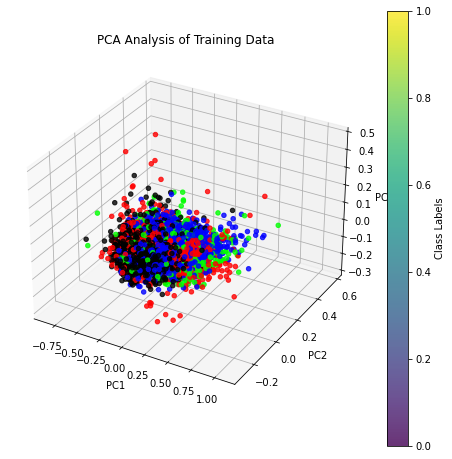

In [14]:
if X_train_pca.shape[1] >= 2:
    visualize_pca(X_train_pca, y_train, title="PCA Analysis of Training Data")

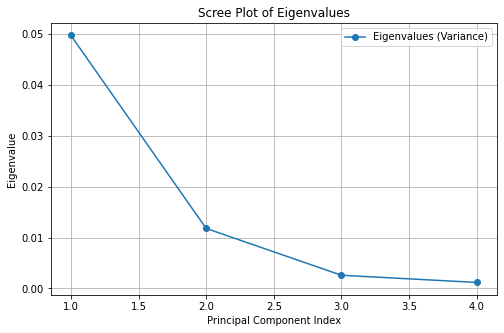

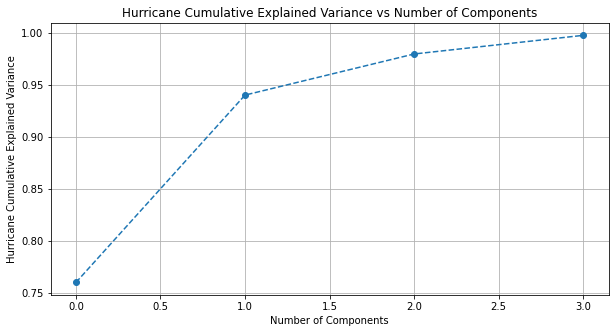

Number of components for 95% variance: 1


In [15]:
#Plotting the cumulative variance
eigenvalues = pca_hur.explained_variance_

# Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', label='Eigenvalues (Variance)')
plt.title("Scree Plot of Eigenvalues")
plt.xlabel("Principal Component Index")
plt.ylabel("Eigenvalue")
plt.grid()
plt.legend()
plt.show()

#Calculating cumulative variance 
cumulative_explained_variance = np.cumsum(pca_ratio)

# Plot cumulative explained variance to see effect of each feature on variance
plt.figure(figsize=(10, 5))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Hurricane Cumulative Explained Variance')
plt.title('Hurricane Cumulative Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

n_components = np.argmax(cumulative_explained_variance >= 95) + 1
print(f"Number of components for 95% variance: {n_components}")

The scree plot also suggest we may be able to just keep 3 of the PCA components. We may not need all of them

Training CE: 18.56
Training Accuracy score: 0.46
Validation CE: 19.17
Validation Accuracy score: 0.44


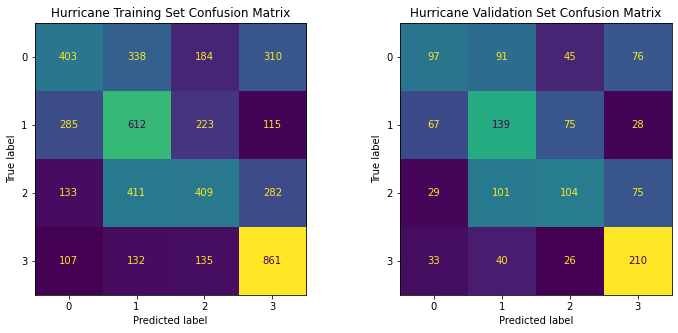

In [17]:
weights, bias = gradient_descent_logistic(X_train_pca, y_train, num_classes, learning_rate=1, reg=0.001, iterations=10000)
y_train_pred = predict(X_train_pca, weights, bias)
y_valid_pred = predict(X_valid_pca, weights, bias)

y_train_pred_ohe = to_one_hot(y_train_pred, num_classes)
y_valid_pred_ohe = to_one_hot(y_valid_pred,num_classes)

train_ce = cross_entropy(y_train, y_train_pred_ohe)
valid_ce = cross_entropy(y_valid, y_valid_pred_ohe)
train_accuracy = accuracy_score(y_train, y_train_pred_ohe)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_ohe)
print(f"Training CE: {train_ce:.2f}")
print(f"Training Accuracy score: {train_accuracy:.2f}")
print(f"Validation CE: {valid_ce:.2f}")
print(f"Validation Accuracy score: {valid_accuracy:.2f}")

y_train_labels = np.argmax(y_train_pred_ohe, axis=1) 
y_valid_labels = np.argmax(y_valid_pred_ohe, axis=1) 
y_train_linear = np.argmax(y_train, axis=1)
y_valid_linear = np.argmax(y_valid, axis=1)

train_cm = confusion_matrix(y_train_linear, y_train_labels)
valid_cm = confusion_matrix(y_valid_linear, y_valid_labels)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(train_cm, display_labels=[0, 1, 2, 3]).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Hurricane Training Set Confusion Matrix")
ConfusionMatrixDisplay(valid_cm, display_labels=[0, 1, 2, 3]).plot(ax=ax[1], colorbar=False)
ax[1].set_title("Hurricane Validation Set Confusion Matrix")
plt.show()

In [17]:
print("X shape: ", X_train_pca.shape)
print("Y shape: ", y_train.shape)

weights, bias = gradient_descent_logistic(X_train_pca, y_train, num_classes, learning_rate=1, reg=0.001, iterations=100000)
y_train_pred = predict(X_train_pca, weights, bias)
y_valid_pred = predict(X_valid_pca, weights, bias)

X shape:  (4940, 4)
Y shape:  (4940, 4)


In [18]:
pca_train_accuracy = accuracy_score(y_train_pred, np.argmax(y_train, axis = 1))
pca_valid_accuracy = accuracy_score(y_valid_pred, np.argmax(y_valid, axis = 1))

print(f"PCA Training Accuracy: {pca_train_accuracy:.2f}")
print(f"PCA Validation Accuracy: {pca_train_accuracy:.2f}")

PCA Training Accuracy: 0.46
PCA Validation Accuracy: 0.46


In [26]:
average_kfold_accuracy = apply_k_fold(X_train_pca, y_train, num_classes=4, k=5)
print(average_kfold_accuracy)

0.4364372469635628


In [20]:
weights_list, bias_list = train_one_vs_rest(X_train_pca, y_train, num_classes=2)

# Make predictions
y_train_pred = predict_one_vs_rest(X_train_pca, weights_list, bias_list)
y_valid_pred = predict_one_vs_rest(X_valid_pca, weights_list, bias_list)


Training class 0 with binary labels
Training class 1 with binary labels
unique predictions 2
shape (2, 4940)
unique predictions 2
shape (2, 1236)


In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_f1_scores(y_true, y_pred, average='macro'):
    """
    Calculate precision, recall, and F1 scores for multi-class classification.

    Args:
    - y_true: Ground truth labels (1D array).
    - y_pred: Predicted labels (1D array).
    - average: Averaging method ('macro', 'weighted', 'micro', or None).

    Returns:
    - precision: Precision score.
    - recall: Recall score.
    - f1: F1 score.
    """
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    
    print(f"Precision ({average}): {precision:.4f}")
    print(f"Recall ({average}): {recall:.4f}")
    print(f"F1 Score ({average}): {f1:.4f}")
    
    return precision, recall, f1


In [35]:
def apply_k_fold(X, y, k, num_classes, learning_rate=1, reg=0.001, iterations=1000, test_set=None):
    """
    Perform k-fold cross-validation for logistic regression with metrics computation.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}  # Initialize storage
    fold_num = 1 

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        weights, bias = gradient_descent_logistic(X_train, y_train, num_classes, learning_rate, reg, iterations)

        # Predict on validation set
        y_valid_pred = predict(X_val, weights, bias)
        y_val_labels = np.argmax(y_val, axis=1)  
        
        # Handle 1D or 2D predictions
        if len(y_valid_pred.shape) == 1:
            y_pred_labels = y_valid_pred  
        else:
            y_pred_labels = np.argmax(y_valid_pred, axis=1)  # Convert probabilities to class indices

        # Compute and append metrics
        accuracy = accuracy_score(y_val_labels, y_pred_labels)
        precision, recall, f1 = calculate_f1_scores(y_val_labels, y_pred_labels, average='macro')
        metrics['accuracy'].append(accuracy)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1'].append(f1)
        
        print(f"\nMetrics for Fold {fold_num}:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")

        fold_num += 1

        if test_set is not None and not test_set.empty:
            generate_test_preds(test_set, weights, bias, pca_hur)

    avg_results = {metric: np.mean(values) for metric, values in metrics.items()}

    print("\nCross-Validation Results (Averages):")
    for metric, value in avg_results.items():
        print(f"{metric.capitalize()}: {value:.4f}")

    return avg_results


In [36]:
# Running k-fold cross-validation with metrics computation
results = apply_k_fold(X_train_pca, y_train, k=5, num_classes=4, learning_rate=0.1, reg=0.01)

print("Final Averaged Metrics:")
for metric, value in results.items():
    print(f"{metric.capitalize()}: {value:.4f}")


Precision (macro): 0.4085
Recall (macro): 0.3964
F1 Score (macro): 0.3326

Metrics for Fold 1:
  Accuracy: 0.3917
  Precision: 0.4085
  Recall: 0.3964
  F1 Score: 0.3326
Precision (macro): 0.3734
Recall (macro): 0.3856
F1 Score (macro): 0.3380

Metrics for Fold 2:
  Accuracy: 0.3856
  Precision: 0.3734
  Recall: 0.3856
  F1 Score: 0.3380
Precision (macro): 0.4282
Recall (macro): 0.4020
F1 Score (macro): 0.3655

Metrics for Fold 3:
  Accuracy: 0.4049
  Precision: 0.4282
  Recall: 0.4020
  F1 Score: 0.3655
Precision (macro): 0.3853
Recall (macro): 0.3989
F1 Score (macro): 0.3624

Metrics for Fold 4:
  Accuracy: 0.3937
  Precision: 0.3853
  Recall: 0.3989
  F1 Score: 0.3624
Precision (macro): 0.4111
Recall (macro): 0.4038
F1 Score (macro): 0.3620

Metrics for Fold 5:
  Accuracy: 0.4038
  Precision: 0.4111
  Recall: 0.4038
  F1 Score: 0.3620

Cross-Validation Results (Averages):
Accuracy: 0.3960
Precision: 0.4013
Recall: 0.3973
F1: 0.3521
Final Averaged Metrics:
Accuracy: 0.3960
Precision:

In [24]:
# Convert predictions and true labels to single-dimensional arrays
y_train_labels = np.argmax(y_train_pred, axis=1)
y_valid_labels = np.argmax(y_valid_pred, axis=1)
y_train_linear = np.argmax(y_train, axis=1)
y_valid_linear = np.argmax(y_valid, axis=1)

# Calculate F1 scores for training and validation sets
train_precision, train_recall, train_f1 = calculate_f1_scores(y_train_linear, y_train_labels, average='macro')
valid_precision, valid_recall, valid_f1 = calculate_f1_scores(y_valid_linear, y_valid_labels, average='macro')

print(f"Training F1 Score: {train_f1:.4f}")
print(f"Validation F1 Score: {valid_f1:.4f}")

def apply_k_fold(X, y, k, num_classes, learning_rate=1, reg=0.001, iterations=1000, test_set=None):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracy_scores = []
    f1_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        weights, bias = gradient_descent_logistic(X_train, y_train, num_classes, learning_rate, reg, iterations)
        
        # Predict on validation set
        y_valid_pred = predict(X_val, weights, bias)
        y_valid_labels = np.argmax(y_valid_pred, axis=1)
        y_val_labels = np.argmax(y_val, axis=1)

        # Accuracy Score
        accuracy = accuracy_score(y_val_labels, y_valid_labels)
        accuracy_scores.append(accuracy)

        # F1 Score
        _, _, f1 = calculate_f1_scores(y_val_labels, y_valid_labels, average='macro')
        f1_scores.append(f1)

        if test_set is not None and not test_set.empty:
            generate_test_preds(test_set, weights, bias, pca_hur)

    avg_accuracy = np.mean(accuracy_scores)
    avg_f1 = np.mean(f1_scores)
    
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    
    return avg_accuracy, avg_f1


Precision (macro): 0.0623
Recall (macro): 0.2492
F1 Score (macro): 0.0997
Precision (macro): 0.0622
Recall (macro): 0.2484
F1 Score (macro): 0.0995
Training F1 Score: 0.0997
Validation F1 Score: 0.0995


/Users/sophia01px2019/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sophia01px2019/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


unique predicted classes: [0 1]
Class distribution in training labels: [1235 1235 1235 1235]
Training Accuracy score: 0.2492
Validation Accuracy score: 0.2484


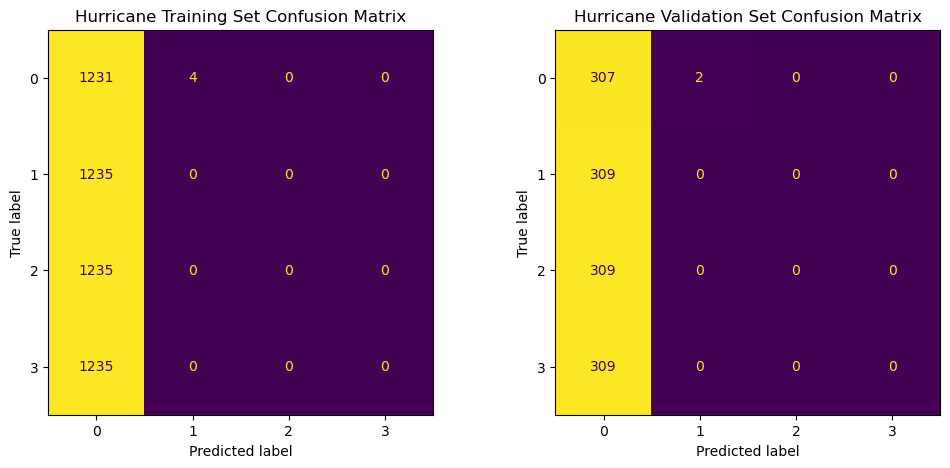

In [279]:
y_train_class = np.argmax(y_train, axis=1)  # shape will be (4940,)
y_valid_class = np.argmax(y_valid, axis=1)  # shape will be (1236,)
y_train_pred_class = np.argmax(y_train_pred, axis=1)  # shape will be (4940,)
y_valid_pred_class = np.argmax(y_valid_pred, axis=1)  # shape will be (1236,)

highest_class = np.argmax(y_train_pred, axis=1)
print("unique predicted classes:", np.unique(highest_class))
print("Class distribution in training labels:", np.bincount(y_train_class))

train_accuracy = np.mean(y_train_class == y_train_pred_class)
valid_accuracy = np.mean(y_valid_class == y_valid_pred_class)

# train_rmse = cross_entropy(y_train, y_train_pred)
# valid_rmse = cross_entropy(y_valid, y_valid_pred)

# print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training Accuracy score: {train_accuracy:.4f}")
# print(f"Validation RMSE: {valid_rmse:.2f}")
print(f"Validation Accuracy score: {valid_accuracy:.4f}")

train_cm = confusion_matrix(y_train_class, y_train_pred_class)
valid_cm = confusion_matrix(y_valid_class, y_valid_pred_class)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(train_cm, display_labels=[0, 1, 2, 3]).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Hurricane Training Set Confusion Matrix")
ConfusionMatrixDisplay(valid_cm, display_labels=[0, 1, 2, 3]).plot(ax=ax[1], colorbar=False)
ax[1].set_title("Hurricane Validation Set Confusion Matrix")
plt.show()

Well... this did not seem like it worked...

### CNN for Hurricane Dataset

In [ ]:
# necessary imports and definitions for this section
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import torch.nn as nn
from PIL import Image

#Used this tutorial for help: https://www.digitalocean.com/community/tutorials/writing-cnns-from-scratch-in-pytorch

#Preprocess the images (resize) so they are all the same size (64 x 64)
def resize(images, size=(64, 64)):
    resized = []
    for image in images:
        image = Image.fromarray(image)
        image = image.resize(size)
        resized.append(np.array(image))
    return np.array(resized)

#Converting to Tensor (for use with PyTorch), and normalizing images
def toTensor(imageset):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
    tensor = [transform(Image.fromarray(image)) for image in imageset]
    return torch.stack(tensor)

# Creating a CNN class
class ConvNeuralNet(nn.Module):

    def __init__(self, num_classes=2): #takes in number of classes, default at 2 for fire/flood dataset
        super(ConvNeuralNet, self).__init__()
        #2 layers with a max pooling layer. 3 kernels for RGB data
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3) 
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        #another 2 layers with a max pooling layer
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) # 2 more layers with another max pooling layer
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(10816, 128) # linear layer
        self.relu1 = nn.ReLU() #ReLU activation function
        self.fc2 = nn.Linear(128, num_classes) #linear layer that maps to the classes
    
    # Moving images through CNN    
    def forward(self, x): 
        out = self.conv_layer1(x) #first conv layer
        out = self.conv_layer2(out) #second conv layer
        out = self.max_pool1(out) #max pooling layer (dimensionality reduction)
        
        out = self.conv_layer3(out) #third conv layer
        out = self.conv_layer4(out) #fourth conv layer
        out = self.max_pool2(out) #max pooling layer (dimensionality reduction)
                
        out = out.reshape(out.size(0), -1) # flattens to 1D before feeding to linear layers
        
        out = self.fc1(out) #first linear layer
        out = self.relu1(out) #activation function
        out = self.fc2(out) #second connected layer
        return out



In [15]:
# loading in the raw images 

disaster_list = ["hurricane-matthew"]

data = {}
split = "train"

with open('config.json') as config_file:
    config = json.load(config_file)
    # data_dir = "/home/jovyan/shared/course/data100-shared-readwrite/fa24_grad_project_data/satellite-image-data"
    data_dir = "satellite-image-data"

for disaster in disaster_list:
    print(f"Loading {split} images and labels for {disaster} dataset...")
    images = get_images(data_dir, disaster, split=split)
    labels = get_labels(data_dir, disaster, split=split)
    data[disaster] = {"images": images, "labels": labels}

# choose hurricane-matthew from our labels list 
disaster = disaster_list[0]

#separate the labels and the images for our EDA
hurricane_matthew_labels = data[disaster]["labels"]
hurricane_matthew_images = data[disaster]["images"]

Loading train images and labels for hurricane-matthew dataset...


In [ ]:
# data cleaning and formatting for the CNN
random.seed(42)

random_0_indeces = random.sample(list(np.where(hurricane_matthew_labels == 0)[0]), 1544)
random_1_indeces = random.sample(list(np.where(hurricane_matthew_labels == 1)[0]), 1544)
random_3_indeces = random.sample(list(np.where(hurricane_matthew_labels == 3)[0]), 1544)
random_2_indeces = random.sample(list(np.where(hurricane_matthew_labels == 2)[0]), 1544)

sum_indeces = random_0_indeces + random_1_indeces + random_3_indeces + random_2_indeces

hurricane_matthew_0_cnn = np.array(hurricane_matthew_labels[random_0_indeces])
hurricane_matthew_1_cnn = np.array(hurricane_matthew_labels[random_1_indeces])
hurricane_matthew_2_cnn = np.array(hurricane_matthew_labels[random_2_indeces])
hurricane_matthew_3_cnn = np.array(hurricane_matthew_labels[random_3_indeces])

hurricane_matthew_labels_eq = np.concatenate([
    hurricane_matthew_0_cnn,
    hurricane_matthew_1_cnn,
    hurricane_matthew_2_cnn,
    hurricane_matthew_3_cnn
])

filtered_images = [hurricane_matthew_images[index] for index in indeces]

hurricane_matthew_resized = resize(filtered_images)

filtered_images = [hurricane_matthew_images[index] for index in hurricane_matthew_labels_eq]

hurricane_matthew_resized = resize(filtered_images)

# convert all images and labels to tensors
hurricane_images_tensor = toTensor(hurricane_matthew_resized)
hurricane_labels_tensor = torch.tensor(hurricane_matthew_labels_eq, dtype = torch.long)

In [38]:
# loader objects for PyTorch
#Split into validation and training sets
X_train_CNN, X_valid_CNN, y_train_CNN, y_valid_CNN = train_test_split(hurricane_images_tensor, hurricane_labels_tensor, test_size=0.2, random_state=42)

#Create tensor datasets to load into the loader object
train_dataset = TensorDataset(X_train_CNN, y_train_CNN)
valid_dataset = TensorDataset(X_valid_CNN, y_valid_CNN)

#Create loader objects (preserves memory by only loading the images batch by batch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)

In [35]:
# hyperparameters 
num_classes = 4 #number of classes in our dataset
learning_rate = 0.001 #initializing initial learning rate

#setting up model using our custom class
cnn_model = ConvNeuralNet(num_classes)

# using cross entropy for the loss function
loss_func = nn.CrossEntropyLoss()

# set optimizer for CNN (stochastic gradient descent)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

#set total length of training data
total_step = len(train_loader)

In [39]:
#takes ~20 mins to run!
num_epochs = 20 #number of times to run the CNN

# set device to run 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Counters for visualization of training loss and accuracy
train_loss = []
train_accuracy = []


for epoch in range(num_epochs):
    #training mode
    cnn_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # user loader object to load the data
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward through the CNN
        outputs = cnn_model(images) 
        loss = loss_func(outputs, labels) #calculate loss
        
        # Backpropagation, optimize parameters
        optimizer.zero_grad() #use SGD to optimize weights
        loss.backward() #check new gradient with loss function
        optimizer.step() #update weights

        running_loss += loss.item() #add all loss over this loop to running_loss

        _, predicted_train = torch.max(outputs.data, 1) # get current prediction for this epoch
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item() #compare prediction with label

    
    # Calculate average loss and accuracy over the epoch
    avg_loss = running_loss / len(train_loader) #gives the average loss over the epoch
    train_loss.append(avg_loss)
    t_accuracy = 100 * correct_train / total_train
    train_accuracy.append(t_accuracy)
    
    
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {}%'.format(epoch+1, num_epochs, avg_loss, t_accuracy))


Epoch [1/20], Loss: 0.2914, Accuracy: 93.78542510121457%
Epoch [2/20], Loss: 0.0002, Accuracy: 100.0%
Epoch [3/20], Loss: 0.0002, Accuracy: 100.0%
Epoch [4/20], Loss: 0.0002, Accuracy: 100.0%
Epoch [5/20], Loss: 0.0002, Accuracy: 100.0%
Epoch [6/20], Loss: 0.0002, Accuracy: 100.0%
Epoch [7/20], Loss: 0.0002, Accuracy: 100.0%
Epoch [8/20], Loss: 0.0002, Accuracy: 100.0%
Epoch [9/20], Loss: 0.0002, Accuracy: 100.0%
Epoch [10/20], Loss: 0.0002, Accuracy: 100.0%
Epoch [11/20], Loss: 0.0002, Accuracy: 100.0%
Epoch [12/20], Loss: 0.0002, Accuracy: 100.0%
Epoch [13/20], Loss: 0.0002, Accuracy: 100.0%
Epoch [14/20], Loss: 0.0002, Accuracy: 100.0%
Epoch [15/20], Loss: 0.0002, Accuracy: 100.0%
Epoch [16/20], Loss: 0.0002, Accuracy: 100.0%
Epoch [17/20], Loss: 0.0002, Accuracy: 100.0%
Epoch [18/20], Loss: 0.0002, Accuracy: 100.0%
Epoch [19/20], Loss: 0.0002, Accuracy: 100.0%
Epoch [20/20], Loss: 0.0002, Accuracy: 100.0%


In [40]:
#Running training set through the optimized CNN to calculate accuracy

#do not need gradient optimization for evaluation 
with torch.no_grad():
    cnn_model.eval() #model in evaluation mode 
    correct = 0 #set initial correct prediction counter to 0 
    total = 0 #total predictions
    for images, labels in train_loader: #loop through images in the loader
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the train images: {} %'.format(100 * correct / total))

Accuracy of the network on the train images: 100.0 %


In [41]:
#Running validation set through the optimized CNN to calculate accuracy

cnn_model.eval() #model in evaluation mode


#collecting metrics from validation evaluation run as well
valid_loss = 0.0
valid_accuracy = []
correct_valid = 0
total_valid = 0

#do not need gradient optimization for validation set
with torch.no_grad(): 
    for images, labels in valid_loader: 
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn_model(images)

        #loss
        loss = loss_func(outputs, labels)
        valid_loss += loss.item()

        #accuracy
        _, predicted_valid = torch.max(outputs.data, 1)
        total_valid += labels.size(0)
        correct_valid += (predicted_valid == labels).sum().item()

avg_valid_loss = valid_loss / len(valid_loader)
valid_accuracy = 100 * correct_valid / total_valid
    
print(f'Validation Loss: {avg_valid_loss:.4f}')
print(f'Validation Accuracy: {valid_accuracy:.2f}%')

Validation Loss: 0.0002
Validation Accuracy: 100.00%


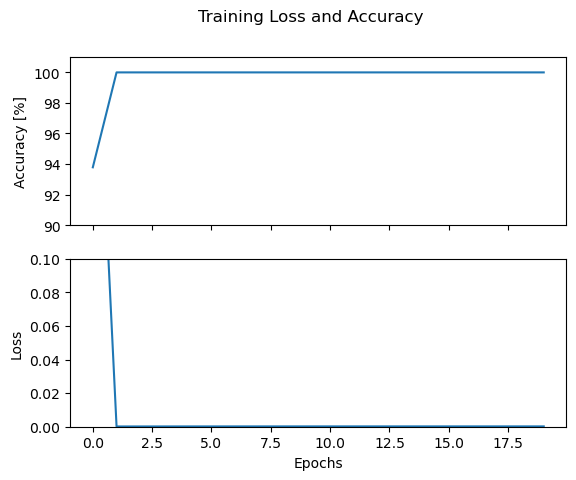

In [42]:
#Visualization of training loss and accuracy

xplot = np.arange(20)

fig1, ax1 = plt.subplots(2, 1, sharex = True)
ax1[0].plot(xplot, train_accuracy)
ax1[0].set_ylabel('Accuracy [%]')
ax1[0].set_ylim(90, 101)
ax1[1].plot(xplot, train_loss)
ax1[1].set_ylabel('Loss')
ax1[1].set_ylim(0, 0.1)

ax1[1].set_xlabel('Epochs')
fig1.suptitle('Training Loss and Accuracy')


plt.show()

## Performance Assessment

Use the model to generate predictions for the `test_images_hurricane-matthew.npz` images. This should be in a CSV file `test_images_hurricane-matthew_predictions.csv` consisting of a single column with no header, with a 0-3 prediction of the damage level. The prediction in row *i* should correspond to the *i*th image.

In [283]:
test_im_hurricane_path = os.path.join(data_dir, "test_images_hurricane-matthew.npz")
test_im_hurricane = load_images(test_im_hurricane_path)

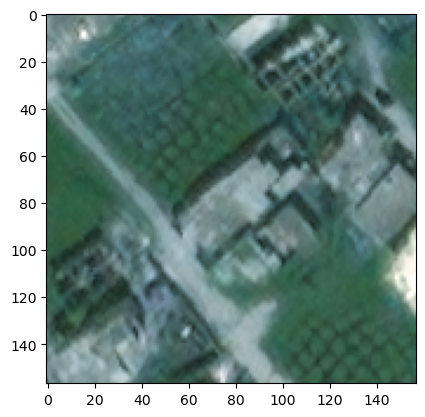

In [284]:
plt.imshow(test_im_hurricane[0]);

In [285]:
test_sobel_edges = img_to_sobel(test_im_hurricane)
test_lbp = img_to_LBP(test_im_hurricane)  
test_red, test_green, test_blue = image_to_RGB(test_im_hurricane)
test_red_log = np.log(np.array(test_red))
test_green_log = np.log(np.array(test_green))
test_blue_log = np.log(np.array(test_blue))  # not used, keeping for consistency
test_gabor = img_to_gabor(test_im_hurricane)

# Combine all features into df
test_features = pd.DataFrame({
    'Sobel_Edges': test_sobel_edges,
    "LBP": test_lbp,
    'Red_Log': test_red_log,
    'Green_Log': test_green_log,
    'Gabor': test_gabor
})

## Logistic

In [290]:
test_predictions = model.predict(test_features)
output_path = "logistic_test_images_hurricane_predictions.csv"
pd.DataFrame(test_predictions).to_csv(output_path, index=False, header=False)

## Gradient

In [ ]:
# we need a column name pred for the predictions ! 

In [298]:
average_kfold_accuracy = apply_k_fold(X_train_pca, y_train, num_classes=4, k=5, test_set=test_features)
pd.DataFrame(test_predictions).to_csv(output_path, index=False, header=False)

print(f"Predictions saved to {output_path}")

Predictions saved to logistic_test_images_hurricane_predictions.csv


## CNN

In [48]:
# Define a loader for the test dataset
test_images = resize(test_im_hurricane)
test_features = toTensor(test_images)

test_dataset = TensorDataset(test_features)

test_loader =  DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

cnn_model.eval() #model in test mode

test_predictions = []

#do not need gradient optimization 
with torch.no_grad(): 
    for images in test_loader: 
        images = images[0].to(device)
        outputs = cnn_model(images)

        _, predicted = torch.max(outputs.data, 1)

        test_predictions.append(predicted.cpu().numpy())

output_path = "cnn_test_images_hurricane_predictions.csv"
pd.DataFrame(test_predictions).to_csv(output_path, index=False, header=False)

print(f"Predictions saved to {output_path}")

Predictions saved to cnn_test_images_hurricane_predictions.csv
